In [3]:
# Read the markdown file
with open('report.md', 'r') as file:
    markdown_content = file.read()

# Display it as markdown
from IPython.display import display, Markdown
display(Markdown(markdown_content))

# Mobile Robots Project: Autonomous Navigation and Control

# Table of Contents
- [Overview](#overview)
  - [Objectives](#objectives)
  - [Hardware](#hardware)
- [Team Members](#team-members)
  - [Role Distribution](#role-distribution)
- [Introduction](#introduction)
  - [Project Demonstration](#project-demonstration)
- [Computer Vision](#computer-vision)
  - [Calibration](#calibration)
    - [Process](#process)
    - [Calibration Parameters](#calibration-parameters)
  - [ArUco Marker Detection](#aruco-marker-detection)
    - [Marker Configuration](#marker-configuration)
  - [Perspective Transform](#perspective-transform)
    - [Computing the Transform Matrix](#computing-the-transform-matrix)
    - [Applying the Transform](#applying-the-transform)
  - [Obstacle Detection](#obstacle-detection)
    - [Processing Pipeline](#processing-pipeline)
    - [Corner Filtering](#corner-filtering)
- [Global Navigation](#global-navigation)
  - [Path Finding](#path-finding)
- [Local Navigation](#local-navigation)
  - [Local Navigation Introduction](#local-navigation-intro)
  - [Control Loop](#control-loop)
  - [Path Following Loop](#path-following-loop)
  - [Obstacle Avoidance Loop](#obstacle-avoidance-loop)
- [Filtering](#filtering)
  - [Extended Kalman Filter Model](#extended-kalman-filter)
    - [Prediction Step](#prediction-step)
    - [Update Step](#update-step)
    - [Noise Covariance Matrices](#noise-covariance-matrices)
- [Motion Control](#motion-control)
- [Conclusion](#conclusion)

## Overview
This project was developed as part of the **Basics of Mobile Robotics (MICRO-452)** course at EPFL, under the supervision of Professor Francesco Mondada from the [MOBOTS Laboratory](https://www.epfl.ch/labs/mobots/).

### Objectives
We aims to develop an autonomous navigation system for the Thymio robot that can:
1. Navigate through a predefined environment with static obstacles using global navigation
2. Dynamically avoid unexpected obstacles using local navigation
3. Maintain accurate position estimation through filtering
4. Reliably reach arbitrary target positions in the environment

### Hardware

| Peripheral            | Model    |
|------------           |----------|
| Robot                 | [Thymio II (MOBSYA)](https://www.thymio.org/) |
| Webcam        | [Aukey Webcam](https://www.aukey.com/) |


## Team Members

Our team consists of four first-year Master's students in Robotics at EPFL:

| Name            | SCIPER  |
|---------------- |---------|
| David XXX       | XXXX    |
| Ines Altemir Mariñas  | 344399 |
| Michel Abela    | 339421  |
| Rayan Gauderon  | 347428  |

### Role Distribution
The project responsibilities are distributed to maximize efficiency while ensuring each team member contributes to multiple aspects of the system:

- **Vision and Environment Processing**: Rayan and Michel
- **Path Planning and Navigation**: Inés and David
- **Robot Control and Localization**: All team members
- **System Integration and Testing**: All team members

## Introduction

Mobile robots that can move on their own are becoming more common in our daily lives, from robots that move boxes in warehouses to those that help at home. One of the main challenges for these robots is finding their way around while avoiding obstacles that might appear in their path.

In this project, we work with the Thymio II robot to create a system that helps it move safely from one point to another. Our solution combines two main ways of navigation: planning a full path ahead of time (using a map), and reacting to new obstacles that weren't there before (when someone puts something in the robot's way).

### Experimental Setup and Design Choices

Our experimental environment consists of a well-defined workspace measuring 120x100 centimeters, providing ample space for navigation while maintaining a controlled testing environment. We implemented several key design choices to create a robust and reliable navigation system:

**Localization System:**
- Utilized ArUco markers for precise positioning
- Markers serve multiple purposes:
  - Defining the map boundaries
  - Marking goal positions
  - Tracking the Thymio robot's current position and orientation

**Test Environment:**
- Modular obstacle system featuring varying sizes (15-30cm)
- Flexible configuration allowing for different testing scenarios
- High-contrast surface to ensure reliable visual detection

**Path Planning Strategy:**
- Implemented a visibility graph approach, optimized for environments with polygonal obstacles

- Key components of the visibility graph algorithm:
  - Creates nodes from robot's starting position, obstacle vertices, and goal position
  - Establishes edges between mutually visible nodes (no obstacle intersections)
  - Applies Dijkstra's algorithm to determine the shortest viable path


**Control Strategy:**
- Developed a proportional control system with dual feedback mechanisms:
  - Dynamically adjusts both linear and angular velocities
  - Maintains smooth transitions between movement phases
  
- Distance-based speed control features:
  - Proportionally reduces linear velocity as robot nears goal
  - Includes safety thresholds for minimum/maximum speeds

- Orientation-based control characteristics:
  - Modulates linear velocity based on angle to target
  - Applies proportional angular velocity corrections
  - Prioritizes orientation alignment before forward movement

### Project Demonstration

Below is a demonstration of our autonomous navigation system in action:

[Insert Video Here]

In this video, you can see:
- The Thymio robot navigating through our test environment
- Real-time path planning and execution
- Dynamic obstacle avoidance in action
- Position tracking with our vision system


## Computer Vision

### Calibration

Camera calibration is a crucial step in our computer vision pipeline, as it helps remove lens distortion and provides essential camera parameters. We implemented our calibration process based on this [OpenCV's guide](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html), using the checkerboard pattern below:

<p align="center">
<img src="img/vision/calibration/checkerboard.png" width="500" alt="checkerboard">
</p>

#### Process

The calibration process involves:
1. Collecting a set of 15 images of a checkerboard pattern from different angles and distances to ensure robust calibration
2. Detecting the inner corners in each image using `cv2.findChessboardCorners()`, followed by corner position refinement to sub-pixel accuracy with `cv2.cornerSubPix()`
3. Using these detections to compute the camera's intrinsic parameters and distortion coefficients with `cv2.calibrateCamera()`

#### Calibration Parameters
The calibration provides two essential outputs:

1. **Camera Matrix**: A 3×3 matrix containing the camera's intrinsic parameters:
   - Focal lengths (fx, fy)
   - Principal point coordinates (cx, cy)
$$
M = 
\left( \begin{matrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{matrix} \right)
$$
2. **Distortion Coefficients**: A vector containing the lens distortion parameters:
   - Radial distortion coefficients (k1, k2, k3)
   - Tangential distortion coefficients (p1, p2)
$$
D = 
\left( \begin{matrix} 
k_1 & k_2 & p_1 & p_2 & k_3
\end{matrix}\right)
$$

Once calibrated, we can undistort any frame from our camera providing a more accurate representation of the scene for subsequent vision processing steps:

```python
def _undistort_frame(self, frame):
    # Get optimal camera matrix to minimize unwanted pixels
    h, w = frame.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(CAM_MATRIX, CAM_DISTORTION, (w, h), 1, (w, h))
    
    # Apply undistortion
    frame = cv2.undistort(frame, CAM_MATRIX, CAM_DISTORTION, None, newcameramtx)
    
    # Crop the frame to remove invalid pixels
    x, y, w, h = roi
    frame = frame[y:y+h, x:x+w]
    return frame
```
### ArUco Marker Detection

Our vision system uses ArUco markers for robust detection and tracking of the robot's position, orientation, and other key elements in the environment. We utilized [OpenCV's Aruco module](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html) with 4x4 markers.

#### Marker Configuration
The system uses different marker IDs for specific purposes:

- IDs 0-3: Corner markers for perspective transformation
- ID 4: Thymio robot position and orientation
- ID 5: Goal position

Here's the initialization of the ArUco detector:

```python
def __init__(self, device_id):
    # Initialize 4x4 ArUco marker detector with 50 unique markers
    self.aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    self.parameters = cv2.aruco.DetectorParameters()
    self.detector = cv2.aruco.ArucoDetector(self.aruco_dict, self.parameters)
```
The detection process uses OpenCV's `detectMarkers()` function, which returns the corners and IDs of all detected markers in the frame.

### Perspective Transform

A perspective transform is implemented  to convert the camera's angled view into a top-down perspective, which is essential for accurate navigation and obstacle detection. We based our implementation on [OpenCV's geometric transformations](https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html). The map used can be find below:

<p align="center">
<img src="img/vision/aruco_markers/map.png" width="500" alt="map environment">
</p>

#### Computing the Transform Matrix

We use the four corner ArUco markers (IDs 0-3) as reference points to compute the perspective transformation matrix. The process involves mapping these source points to destination points that represent a rectangular top-down view:

```python
def _compute_perspective_transform(self, source_points, world_width, world_height):
    # Calculate pixel to millimeter scale factor
    self.scale_factor = CAM_RESOLUTION[1] / world_width
    
    # Calculate dimensions of transformed image
    dest_width = world_width * self.scale_factor 
    dest_height = world_height * self.scale_factor 
    
    # Define destination points for top-down view
    dest_points = np.float32([
        [0, dest_height],          # bottom-left
        [dest_width, dest_height], # bottom-right
        [0, 0],                    # top-left
        [dest_width, 0]            # top-right  
    ])
    
    # Calculate perspective transformation matrix
    self.perspective_matrix = cv2.getPerspectiveTransform(source_points, dest_points)
```

#### Applying the Transform

Once we have the transformation matrix, we can convert any frame to a top-down view using `cv2.warpPerspective`:

```python
def get_frame(self):
    # Capture frame and apply perspective transform
    original_frame = self._get_original_frame()
    process_frame = cv2.warpPerspective(original_frame, 
                                      self.perspective_matrix, 
                                      self.process_roi)  
    return original_frame, process_frame
```

This transformation allows us to:
- Convert camera coordinates to real-world coordinates
- Obtain accurate measurements for robot navigation
- Simplify obstacle detection and path planning algorithms

### Obstacle Detection

Our obstacle detection system combines Canny edge detection and contour finding from OpenCV to identify obstacles in the environment. The implementation is based on [OpenCV's Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) and [Contour Detection](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html) tutorials. A typical environment with different shape obstacles can be seen below:

<p align="center">
<img src="img/vision/obstacles/obstacles.jpg" width="500" alt="obstacles">
</p>

#### Processing Pipeline

The obstacle detection follows a multi-stage image processing pipeline designed to reliably identify obstacles of various shapes and sizes:

**Image Preprocessing**:
First, we prepare the image for edge detection through several preprocessing steps:
```python
# Convert to grayscale and apply Gaussian blur
gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

# Apply Otsu's thresholding
_, threshold_frame = cv2.threshold(blurred_frame, 0, 255, 
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)
```
The Gaussian blur helps reduce noise while preserving edges, and Otsu's thresholding automatically determines the optimal threshold value for binarization.

**Edge Detection**:
We use the Canny edge detector, which is known for its ability to detect true edges while minimizing false detections:
```python
# Apply Canny edge detection
edges_frame = cv2.Canny(threshold_frame, 50, 150)
```
The parameters 50 and 150 represent the lower and upper thresholds for the hysteresis procedure in Canny edge detection.

<p align="center">
<img src="img/vision/obstacles/edges_detection.png" width="600" alt="egdes">
</p>

**Contour Detection and Processing**:
After edge detection, we find and process contours to identify obstacle boundaries:
```python
# Find contours of obstacles
contours, _ = cv2.findContours(edges_frame, 
                              cv2.RETR_EXTERNAL, 
                              cv2.CHAIN_APPROX_SIMPLE)

# Process each contour above minimum area threshold
for contour in contours:
    if cv2.contourArea(contour) <= OBSTACLE_MIN_AREA:
        continue
        
    # Approximate contour with polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2).astype(np.float32)
```
We use `cv2.RETR_EXTERNAL` to only retrieve the outer contours, and `cv2.CHAIN_APPROX_SIMPLE` to compress horizontal, vertical, and diagonal segments and leave only their end points. The `OBSTACLE_MIN_AREA` threshold helps filter out small noise contours.

<p align="center">
<img src="img/vision/obstacles/contours_detection.png" width="600" alt="contours">
</p>

#### Corner Filtering

To ensure accurate obstacle representation while minimizing computational complexity, we implement a corner filtering mechanism that removes redundant points:

```python
def _filter_close_corners(self, corners, min_distance=10):
    # Return empty list if no corners
    if len(corners) == 0:
        return corners
    
    corners = np.array(corners)
    filtered_corners = [corners[0]]
    
    # Keep corners that are at least min_distance away from all kept corners
    for corner in corners[1:]:
        if all(utils.distance(corner, kept_corner) >= min_distance 
               for kept_corner in filtered_corners):
            filtered_corners.append(corner)
    
    return np.array(filtered_corners)
```

This filtering process:
- Starts with the first corner point
- Adds subsequent corners only if they are at least `min_distance` pixels away from all previously kept corners
- Helps create a more efficient representation of obstacles while maintaining their shape accuracy

Finally, the detected obstacle corners are converted from pixel coordinates to millimeters using our perspective transform scale factor. This conversion is crucial for the navigation system as it needs real-world measurements to plan paths and avoid obstacles effectively.

The combination of these processing steps creates a robust obstacle detection system that:


✓ Works reliably under varying lighting conditions \
✓ Handles obstacles of different shapes and sizes \
✓ Provides accurate position information in real-world coordinates \
✓ Minimizes false detections through filtering

## Global navigation
The aim of global navigation is to find a collision-free optimal path from the start position to the goal position. This is a strategic task. To this end, we must gather a global map of the environment, a start and goal position (obtained from the camera at the initialization/beginning) , a path planning algorithm (Djikstra's algorithm in our case) and a path following module (name??). ((Furthermore, optimality can be defined with respect to different criteria, such as length, execution time, energy consumption and more. In our case, the visibility ???))

This function is fulfilled by the Global Navigation module.

We possess a model of the environment, with some initial "fixed/permanent" obstacles. These obstacles are assumed to be permanent for the duration of the trial. Nonetheless, this does not mean all obstacles are included, as some unexpected (unrecorded) physical obstacles can be put in the map in the robot's path at any point in time, and the Local Navigation module is reponsible for avoiding a collision and returning/recomputing a global path.

The path finding is done in two parts :  the creation of the visibility graph and the computing of the optimal(??) path. 

((Questions: Do we need to take into account geometry,
kinematics constraints, and/or the dynamics of the robot?
(??mention when this computation is reinitialized, ex for kidnapping)))

1. Image of map, with obstacles, start, end !!!

### Visibility Graph
First of all, for the task of graph creation, to capture the connectivity of the free space into a graph that is subsequently searched for paths, we used the road-map approach of Visibility Graphs. To this end, we utilize the PyVisGraph library, who given a set of simple obstacle polygons, builds a visibility graph. The reason behind the use of this module is due to its already optimized functioning and the ease of implementation (ARGUE CHOICE OF VISIBILITY GRAPHS??). Furthermore, this same module possesses a shortest_path() function. This approach guarantees finding the shortest geometric path between start and goal. 

In the _compute_trajectory(self, obstacles_pos, thymio_pos, goal_pos) function, we use the build() method of the PyVisGraph class to compute the graph. This method takes a list of PyVisGraph polygons. 
#### Build visibility graph
        graph = vg.VisGraph()
        graph.build(polygon_obstacles, status=False)
The way build() creates the graph is by identifying all vertices, and then connecting pairs of vertices with edges if the straight line between them doesn't intersect any polygon obstacles.

This list pf PyVisGraph polygons is constructed from a list of points array defining the shape of all the obstacles. Before handing these obstacles to the Visibility Graph build() method, we must perform an a priori expansion of obstacles, taking into account the dimensions/geometry of the Thymio Robot and a security margin, for our algorithm to be implemented robustly. This is done in the _extend_obstacles(self, corners, thymio_width) function, with the SECURITY_MARGIN = 60 #mm, whose has value has been empirically proven to be sufficient to not graze obstacles. This additional step is necessary due to the fact our technique make the assumption of a mass-less, holonomic, pointlike robot (DOES OUR COMPUTER VISION DO THAT??). 
  
### Path Planning 
After having created the visibility graph, we can employ the shortest_path() method in the PyVisGraph class. This method uses the Dijkstra algorithm to compute the optimal path with a given start and goal position. This is done in the _compute_trajectory(self, obstacles_pos, thymio_pos, goal_pos) function.

2. IMAGE OF COMPUTED GLOBAL PATH WITHS OBSTACLES !!!

Finally, the get_trajectory(self, img, thymio_pos, goal_pos, obstacles_pos, thymio_width, scale_factor) function combines everything and handles the visualization. 


### Considerations/Assumptions made and potential improvements
- The computational complexity of this implementation (VisGraph creation) is O(n²log n) where n is the number of vertices ###IMPROV !!!REF. This is acceptable for static environments with relatively few obstacles, but could be problematic for highly complex or dynamic environments ###IMPROV. Alternative approaches could have been: (1) Rapidly-exploring Random Trees (RRTs) - better for dynamic environments (2) Potential Fields - simpler but can get stuck in local minima (3) Grid-based methods (A*, D*) - easier to implement but less smooth paths ---> higher contraint regarding motion control, magnification of motion control error
  
- Our implementation of global navigation does not account for dynamic obstacles. We do not, with the use of the camera vision, update the obstacles if a new one is detected. This is done intentionally in order to test and put to challenge the local navigation, which is capable of reacting to unexpected and unknown obstacles. We might even recompute a new global path, after having done local obstacle avoidance. Therefore, our recovery behaviors if the path becomes blocked is to recompute a new global path. COMPLETENES??
  
- Regarding the uncertainty on the position of the robot and the detection of the obstacles, we have chosen the value of SECURITY_MARGIN large enough to englobe the uncertainty covariance (camera measurement??).
  
- Furthermore, the potential issues arising from treating the robot as a point, in terms of robot kinematics and dynamics, are taken care of in the Local Navigation module, where we establish a MAX_ROTATION_SPEED, a MIN_TRANSLATION_SPEED, a MAX_TRANSLATION_SPEED and much more. 

- Additionally, one may observe that the global paths outputted by the visibility graph algorithm are angular (visibility graphs naturally produce straight-line segments), not possessing any smoothness at all. This is done intentionally, in order to simplify the robot dynamics to the maximum extent possible, as implementing a gradually increasing angular velocity, or multiple reorientations, may exacerbate error, rather than doing a punctual re-orientation. (WE ONLY DO STRAIGHT LINES?? should always have w = 0, except at waypoints, Robot orientation at waypoints). Indeed, we are prioritizing geometric optimality over smooth paths. COMPARISON TO GRID-BASED MAPS??. This graph + algorithm allows us to construct a path that seeks to minimise the complexity of motion control, in a bid to minimise the magnification of motion control error. 

((Navigation algorithm properties:
• Optimality: does the planner find trajectories that are optimal in some sense (length,
execution time, energy consumption)? YES DIJSTRA + VIS GRAPH ENSURE shortest path, considering enlarged obstacles ??
• Completeness: does the planner always find a solution when one exists? COMPLETENESS OF DIJSTRA??
• Offline / online: Can the solution be computed in real time or is too heavy computationally? RUNTIME OF COMPUTATION OF GLOBAL PATH?? seems to be able to be computed in real time, as is recomputed for kidnapping case
Note that most existing techniques make the assumption of a mass-less, holonomic, pointlike robot => may require low-level motion control (??) and a priori expansion of obstacles to be implemented robustly))

## Local Navigation

### Local Navigation Introduction

Let’s talk about the Local Navigation module. It helps the Thymio follow the path computed by the Global Navigation module, and at the same time dynamically avoid 3D obstacles that get in its way… The code for this section can be found in the local_navigation.py file.
The path is given to the Thymio as a list of tuples (px, py) representing the waypoints to follow in order.

### Control Loop

The “get_command” function inside the LocalNav() class runs in a loop, and decide wether the Thymio should be in a path following mode or in obstacle avoidance. The loop starts by checking if an obstacle is in front of the robot using the proximity sensors: if its the case, the robot goes into the obstacle avoidance routine, and if not, the robot can start following the path.
In case the Thymio previously detected and avoided an obstacle, the avoidance routine will be run for the following 7 loop cycles (tunable by modifying “OBSTACLES_MAX_ITER” constant) before going back to the path following mode, to ensure the obstacle is no longer in its way.

### Path Following Loop

The “_trajectory_following” function in the LocalNav() class makes sure the robot stays on the desired path by constantly checking the distance and angle differences between the actual pose of the robot and the next waypoint to be reached. In order to do so, it uses the “_calculate_motion_commands” function that implements a proportional controller on both translation and rotation dynamics, which computes the “forward_speed” (which is the base speed of left/right motors) and the “rotation_speed” (which is the speed increment of each of the left/right motors).
The two proportional controller have been tuned empirically by trial and error to obtain the best performance possible of the system as a whole.

### Obstacle Avoidance Loop


<p align="center">
<img src="img/local_nav/figure_ANN_TP.png" width="500" alt="local_nav_ann">
</p>

The obstacle avoidance routine (“_avoid_obstacles” function in the LocalNav() class) is a simple implementation of the Artificial Neural Network we saw during one of the practical sessions of the course.
The input of the neural network are the readings of the proximity sensors, which are then multiplied by the weights and summed together to get the speed assigned to each of the motors. We do not consider the readings of the proximity sensors on the back of the robot since it will always move forward so it shouldn’t detect any obstacle from the rear. 
Once the Thymio avoided an obstacle, to make sure it is completely gone, the robot checks a few times the sensors before going back to the path_following mode.

<p align="center">
<img src="img/local_nav/local_nav_mindmap.png" width="500" alt="local_nav_mindmap">
</p>


## Filtering
- The motivation behind filtering is the fact that we seek to represent a world which is perceived with errors, on which we do actions that do not correspond exactly to our oders, and with maps that are uncertain. To this end, we im to improve the estimation of our state X, after having incorporated sensor data. 
- We assume a static world and focus on estimating only the pose of a kinematic mobile robot
- The widely used approximations are: Linearization and parametrization for Gaussian filters. The EKF, when performing localization, has the motion and measurement models linearized (using the Jacobian matric)

The filtering module's core purpose is robust state estimation for robot localization by fusing multiple data sources, both the computer vision positioning data and the wheel odometry obtained from the Thymio. Furthermore, it possesses a fallback capability, as it maintains position tracking using odometry when vision data is unavailable/unreliable, be it because the camera is covered or because the computer vision submodule is malfunctioning. 

It performs the state estimation of the differential-drive robot, tracking robot pose (x, y, θ) and linear and angular velocity (v, w) using a nonlinear motion model. We employ a simplified discrete time state space model, assuming a sufficiently small timestep:

$$ \begin{align*} 
x_{i+1} &= x_i + v_i \cdot \Delta t \cdot \cos(\theta_i) \\ 
y{i+1} &= y_i + v_i \cdot \Delta t \cdot \cos(\theta_i)\\ 
\theta{i+1} &= \theta_i + \omega_i \cdot \Delta t \\
v{i+1} &= v_i \\
\omega_{i+1} &= \omega_i 
\end{align*} $$

EXPLAIN WE DON'T VARY (FIXED) V AND W between two segments, two control inputs.
Since the model that we have chosen is nonlinear with respect to the orientation of the robot, standard Kalman filter formulation İs not sufficient. For this reason, we used the Extended Kalman Filter model.

The Extended Kalman Filter implementation handles this by processing measurements from both sensors, weighting data based on sensor uncertainty, linearizing the nonlinear motion model around current state estimates, and providing filtered state estimates robust to sensor failures.

EXPAND ON LIMITATIONS & ASSUMPTIONS

### Extended Kalman Filter Model
We assume a system described by the following nonlinear models:

$$ 
\begin{align*}
\hat{x}_k = f(\hat{x}_{k-1}, u_{k-1}) - w_{k-1}
\end{align*}
$$

where $$\hat{x}_k$$ is the state vector at time $$k$$, $$u_{k-1}$$ is the control input, $$f$$ is the nonlinear state transition function, and $$w_{k-1}$$ is the process noise, assumed Gaussian with zero mean and covariance matrix $$Q_{k-1}$$. 

$$ \begin{align*}
x =
\begin{bmatrix}
x \\
y \\
\theta \\
v \\
\omega
\end{bmatrix}
\end{align*}$$


This nonlinear state transition function $$f$$ is: 
##### State Transition Model

$$
\begin{align*}
x_{\text{next}} &= x + v \cdot \cos(\theta) \cdot \Delta t \\
y_{\text{next}} &= y + v \cdot \sin(\theta) \cdot \Delta t \\
\theta_{\text{next}} &= \theta + \omega \cdot \Delta t \\
v_{\text{next}} &= v \\
\omega_{\text{next}} &= \omega
\end{align*}
$$

Furthermore, the state transition matrix $$F$$ can be found by calculating the Jacobian of the nonlinear state transition model $$f$$ with respect to the state $$x$$. 

$$\begin{align*}
F = 
\begin{bmatrix}
1 & 0 & - v \cdot \sin(\theta_i) \cdot \Delta t &  \cos(\theta) \cdot \Delta t & 0\\
0 & 1 & v \cdot \cos(\theta) \cdot \Delta t &  \sin(\theta) \cdot \Delta t & 0 \\
0 & 0 & 1 & 0 & \Delta t \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\end{align*}
$$

The state transition is implemented in the predict(self, u) function, which will be explicited in the Prediction Step part.
        
##### Observation Model

$$ \begin{align*}
z_k = h(\hat{x}_k) + v_k
\end{align*}$$

where $$z_k$$ is the observation vector, $$h$$ is the observation function and $$v_k$$ is the measurement noise, assumed Gaussian with zero mean and covariance matrix $$R_k$$.

Our measurement function $$h$$ is:

$$\begin{align*}
h(x_i) = \begin{bmatrix} 
x_{\textrm{camera}}\\
y_{\textrm{camera}}\\ 
\theta_{\textrm{camera}}\\ 
v{\textrm{sensor}}\\ 
\omega{\textrm{sensor}} 
\end{bmatrix} 
\end{align*} $$

and the measurement Jacobian $$H$$ is simply the 5x5 identity matrix.

#### Prediction Step
We predict the state at time $$k$$:


$$ \begin{align*}
\hat{x}_k^- = f(\hat{x}_{k-1}, u_k)
\end{align*}$$


$$ \begin{align*}
P_k = F_k P_{k-1} F_k^T + Q_k
\end{align*}$$

and compute the predicted covariance $$P_k$$ of the state estimate. 

This Prediction step is done in the predict(self, u) function. 

        # Extract states
        x, y, theta, _, _ = self.state
        v_l, v_r = u
        
        v, omega = self._compute_velocity(v_l, v_r)
        
        # Predict next state using motion model
        x_next = x + v * np.cos(theta) * self.dt
        y_next = y + v * np.sin(theta) * self.dt
        theta_next = theta + omega * self.dt
        v_next = v
        omega_next = omega
        
        self.state = np.array([x_next, y_next, theta_next, v_next, omega_next])
        
        # Compute Jacobian of state transition
        F = np.eye(self.n)
        F[0, 2] = -v * np.sin(theta) * self.dt
        F[0, 3] = np.cos(theta) * self.dt
        F[1, 2] = v * np.cos(theta) * self.dt
        F[1, 3] = np.sin(theta) * self.dt
        F[2, 4] = self.dt
        
        # Update covariance
        self.P = F @ self.P @ F.T + self.Q

#### Update Step
% Kalman Gain Calculation

$$ \begin{align*}
K_k = P_k H_k^T(H_k P_k H_k^T + R_k)^{-1}
\end{align*}$$

% State Update

$$ \begin{align*}
\hat{x}_k = \hat{x}_k + K_k(z_k - h(\hat{x}_k))
\end{align*}$$

% Covariance Update

$$ \begin{align*}
P_k = (I - K_k H_k)P_k
\end{align*}$$

% Jacobian Matrices

$$ \begin{align*}
F_k = \left.\frac{\partial f}{\partial x}\right|_{\hat{x}_{k-1}, u_k}
\end{align*}$$

$$ \begin{align*}
H_k = \left.\frac{\partial h}{\partial x}\right|_{\hat{x}_k}
\end{align*}$$

We implement this in the following function update(self, measurement):
        
        measurement[3], measurement[4] = self._compute_velocity(measurement[3], measurement[4])
        
        # Measurement matrix 
        H = np.eye(self.n)
        
        # Compute Kalman gain
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state and covariance
        y = measurement - self.state
        
        # Normalize angle difference [-pi, pi]
        y[2] = np.arctan2(np.sin(y[2]), np.cos(y[2]))
        
        self.state = self.state + K @ y
        self.P = (np.eye(self.n) - K @ H) @ self.P

#### Noise Covariance Matrices
In the aim of obtaining the values of the process noise covariance $$Q$$ and measurement noise covariance $$R$$ matrices, we have performed extensive experiments. 
Such set-up and results are found in the run_test.ipynb notebook. 

In this notebook, we first perform a speed conversion test, which allows us to determine the value of SPEED_TO_MM_S = 2.9466 (??)

Afterward, we perform a camera covariance test, representing the measurement error on x, y and theta. For this task, we collect a sample of 500 camera photographs of the a given map configuration, obstacle selection and robot position. Using our Vision module to obtain the Thymio position and orientation from such a frame, we then compute the Covariance on x, y and theta. 
##### Camera Noise Covariance Test 

    n_samples = 500
    positions = np.zeros((n_samples, 2))  # For x,y positions
    orientations = np.zeros(n_samples)    # For orientation values
    
    try:
        vision.connect_webcam()
       
        print("Collecting camera data...")
        vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)
        found_thymio = False
        for i in tqdm(range(n_samples)):
            _, process_frame = vision.get_frame()
            frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
            if found_thymio:
                positions[i] = thymio_pos[:2] # Store x,y positions
                orientations[i] = thymio_pos[2] # Store orientation values
            else:
               # We want 500 samples, so if we don't find the Thymio, we need to go back one step
                i -= 1
            time.sleep(DT)

The odometry measurement noise on the linear velocity $$v$$  is established by performing 5 trials at 6 selected target values of the speed. The targed_speeds are communicated to the Thymio as a control input set_motor_speed(target_v, target_v), having the left and right velocity equal to the target velocity. Finally, we collect the Thymio's odometry values with: left, right = get_motor_speed(). We therefore obtain the error distribution at different target speeds. 
##### Odometry Noise Covariance Test
    all_samples = []
    target_speeds = [100, 120, 140, 160, 180, 200]
    
    for target_v in target_speeds:
        input(f"Press enter for speed {target_v}...")
        for i in range(5):
            input("Press enter for next trial...")
            print(f"Testing speed: {target_v}, trial {i + 1}")
            clear_output(wait=True)
            set_motor_speed(target_v, target_v)
            time.sleep(1)  # Stabilize
            
            samples = []
            for _ in range(50):
                left, right = get_motor_speed()
                v = (left + right) / 2
                samples.append(v)
                time.sleep(DT)

A similar approach is followed to compute the measurement noise on the angular velocity $$\omega$$. This also forms part of the odometry measurement error. 

Thanks to the experiments done, we can therefore define, at the beginning of the extended_kalman_filter.py file: 

Values obtained in run_tests.ipynb
R_COVERED = np.diag([9999999, 9999999, 9999999, 35.8960, 154.1675]) # No measurement from camera

R_UNCOVERED = np.diag([0.11758080, 0.11758080, 0.00002872, 35.8960, 154.1675])

Due to the fact that the camera vision can be covered, we define two different measurement noise covariance matrices $$R$$, more precisely $$R_{COVERED}$$ and $$R_{UNCOVERED}$$. When the camera is covered, and therefore camera measurements aren't available, the measurement noise covariances on (x, y , theta) are set to near-infinite values. This effectively tells the Kalman filter to ignore any position/orientation measurements during these periods and rely solely on the motion model prediction and odometry measurements. This is a common technique in Kalman filtering when certain sensors become temporarily unavailable - setting their corresponding measurement uncertainties to very high values effectively disables their influence on the state estimate.
There is a method in the extended_kalman_filter.py file to detect this covering of the camera and set the measurement noise covariance matrix to the corresponding value:

def set_mode(self, covered):
        if covered:
            self.R = R_COVERED # No measurement from camera
        else:
            self.R = R_UNCOVERED # Measurement from camera

For the Process noise covariance matrix $$Q$$, we perform two tests: for the process noise on the position (x,y) and the linear velocity v, and for the process noise on the orientation theta and the angular velocity $$\omega$$. As we have already computed the camera measurement noise, and have verified that it has very low values, for the following tests we will assimilate the computer vision to the ground truth, and use it to compute the process noises. 

The x,y and v process noise covariance test is done in the following manner. We have a selection of target speeds, and for each value we do 5 trials. At each target speed, we set the motor speed to that target, let the robot move during a certain timespan, collect the actual_position of the robot at different timestamps through the camera vision, and analytically compute the expected_position of the robot at each timestamps using the state transition model detailed previously. With these two values, we can compute the process variance on x, y and v. 

      target_speeds = [100, 120, 140, 160, 180, 200]
      #all_variances = {speed: [] for speed in target_speeds}
      # MODIFICATION
      all_variances = {speed: {'pos': [], 'vel': []} for speed in target_speeds}
      
      for speed in target_speeds:
          input(f"Testing speed {speed}...")
          for trial in range(5):
              motor_stop()
              clear_output(wait=True)
              input(f"Trial {trial + 1}: Place robot at start, press enter...")
              print(f"Testing speed: {speed}, trial {trial + 1}")
              found_thymio = False
              vision.flush()
              while not found_thymio:
                  _, process_frame = vision.get_frame()
                  _, initial_pos, found_thymio = vision.get_thymio_position(process_frame)
              set_motor_speed(speed, speed)
              time.sleep(1)
              
              expected_positions = []
              actual_positions = []
              # MODIFICATION
              actual_velocities = []
              t = 0
              last_pos = initial_pos[:2]
              last_time = time.time()
              
              for _ in range(30):
                  current_time = time.time()
                  _, frame = vision.get_frame()
                  _, pos, found = vision.get_thymio_position(frame)
                  if found:
                      expected_x = initial_pos[0] + speed / SPEED_TO_MM_S * np.cos(pos[2]) * t
                      expected_y = initial_pos[1] + speed / SPEED_TO_MM_S * np.sin(pos[2]) * t
                      expected_positions.append([expected_x, expected_y])
                      actual_positions.append(pos[:2])
  
                      # Calculate actual velocity
                      dt = current_time - last_time
                      if dt > 0:
                          dx = pos[0] - last_pos[0]
                          dy = pos[1] - last_pos[1]
                          actual_v = np.sqrt(dx**2 + dy**2) / dt
                          actual_velocities.append(actual_v)
                      
                      last_pos = pos[:2]
                      last_time = current_time
  
                  t += DT
                  time.sleep(DT)
              
              motor_stop()
              diffs = np.array(actual_positions) - np.array(expected_positions)
              print(f"Differences - X: {np.mean(diffs[:, 0]):.4f}, Y: {np.mean(diffs[:, 1]):.4f}")
              
              position_var = np.var(diffs, axis=0)
              all_variances[speed].append(position_var)
  
              # Velocity variance calculation
              target_v = speed / SPEED_TO_MM_S  # Convert to mm/s
              velocity_diffs = np.array(actual_velocities) - target_v
              velocity_var = np.var(velocity_diffs)

Finally, for the orientation theta and angular velocity w process noise covariance, we perform a similar test. Having a selection of target speeds, running multiple trials at each value, having a timespan during which we use the camera vision to collect actual_angles, and using the state transition model to compute expected_angle, and using the comparison of these two values to compute the process noise covariance on $$\theta$$ and $$\omega$$. 
            
Values obtained in run_tests.ipynb
Q = np.diag([79.0045, 79.0045, 0.0554, 0.01, 0.01])


## Motion Control

<p align="center">
<img src="img/motion_control/motion_control.svg" width="500" alt="motion_control">
</p>

## Conclusion



## Code Implementation

### Install Required Dependencies

In [18]:
!pip install -r requirements.txt

### Import Libraries

In [1]:
# External imports
import numpy as np
import time
import tdmclient.notebook

# Internal imports
from scripts.vision import Vision
from scripts.global_navigation import GlobalNav
from scripts.local_navigation import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

### General Configuration

In [ ]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 1300  # mm
WORLD_HEIGHT = 900 # mm
WORLD_MAP = np.array([WORLD_WIDTH, WORLD_HEIGHT])

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm
SPEED_TO_MM_S = 1.5 # Found experimentally (cf run_tests.ipynb)

# Kidnapping configuration
KIDNAP_THRESHOLD = 40 # mm

### Initialize Classes

In [3]:
vision = Vision(DEVICE_ID)
global_nav = GlobalNav()
local_nav = LocalNav()
ekf = ExtendedKalmanFilter(DT, THYMIO_WHEEL_BASE)

Vision initialized correctly.
GlobalNav initialized correctly.
LocalNav initialized correctly.
EKF initialized correctly.


### Start Thymio

In [4]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


### Define Thymio Functions

In [5]:
@tdmclient.notebook.sync_var
def set_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def get_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


### Test Thymio Functions

In [6]:
set_speed(100, 100)
time.sleep(1)
v_l, v_r = get_speed()
print(f"Current speeds: {v_l}, {v_r}")
motor_stop()

Current speeds: 99, 91


### Test Camera

In [7]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    start_time = time.time()
    while time.time() - start_time < 3:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.


### Get perspective view, thymio, goal and obstacles position, trajectory planning

Webcam disconnected correctly.

=== Obstacles Information ===
Number of obstacles detected: 3
Obstacle coordinates [mm]:

Obstacle 1:
    Corner 1: [658.4, 664.4]
    Corner 2: [659.6, 819.7]
    Corner 3: [1042.4, 817.3]
    Corner 4: [1038.8, 660.8]

Obstacle 2:
    Corner 1: [376.8, 252.8]
    Corner 2: [191.4, 350.3]
    Corner 3: [303.3, 560.9]
    Corner 4: [488.7, 464.6]

Obstacle 3:
    Corner 1: [687.3, 137.2]
    Corner 2: [619.9, 262.4]
    Corner 3: [776.4, 421.3]
    Corner 4: [905.2, 174.5]

=== Thymio Information ===
Position [mm]: [1165.2, 162.5]
Orientation [°]: 146.6

=== Goal Information ===
Position [mm]: [126.4, 746.3]

=== Trajectory Information ===
Number of waypoints: 2
Waypoint path [mm]:
Checkpoint 1: [793.9, 524.8]
Checkpoint 2: [126.4, 746.3]


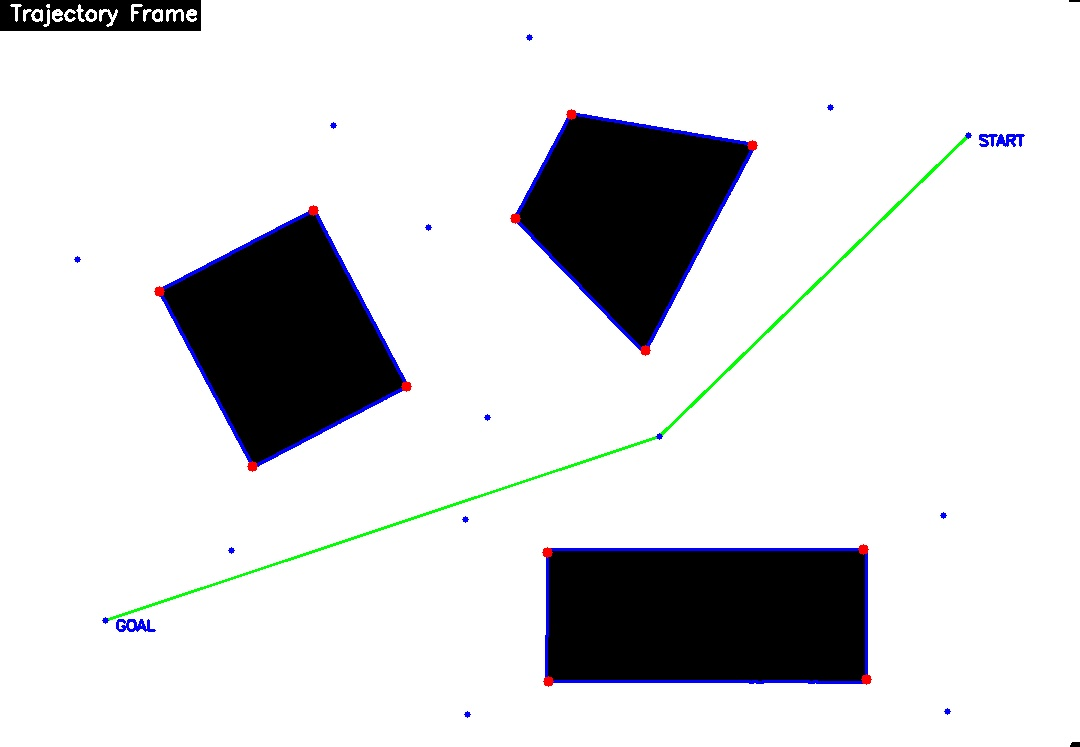

In [9]:
# Display variables
obstacles_img = None
trajectory_frame = None

# Positions variables
thymio_pos = None
goal_pos = None
trajectory_pos = None
obstacles_pos = None

# Flags variables
found_thymio = False
found_goal = False
found_trajectory = False

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    
    input("Press Enter to calculate the perspective vision...")
    
    # Get the perspective parameters for processing frame and return the scale factor for pixels to mm conversion
    vision.get_perspective_parameters(WORLD_MAP)
    
    # Display the original and processed frames
    original_frame, process_frame = vision.get_frame()
    utils.display_frames(original_frame, process_frame, None)
    
    input("Press Enter to get the obstacles position...")
    
    vision.flush()
    # Get the obstacles position
    _, process_frame = vision.get_frame()
    obstacles_pos, obstacles_img = vision.get_obstacles_position(process_frame)
    
    input("Press Enter when thymio and goal position have been placed on the map...")
    
    vision.flush()
    # Get the goal position and thymio position
    while not found_thymio:
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        time.sleep(DT)
    
    print("Thymio detected!")
    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
    
    while not found_goal:
        _, process_frame = vision.get_frame()
        frame, goal_pos, found_goal = vision.get_goal_position(process_frame)
        time.sleep(DT)
    print("Goal detected!")
    print(f"Goal position [mm]: {np.round(goal_pos, 1)}")
    
    utils.display_frames(None, frame, None)
    
    input("Press Enter to get the trajectory from thymio to goal position...")
    
    vision.flush()
    # Get the trajectory from thymio to goal position
    while not found_trajectory:
        _, frame = vision.get_frame()
        trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                       THYMIO_WIDTH, vision.scale_factor)    
        time.sleep(DT)
         
    # Initialize the EKF
    ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0])) # x, y, theta, v, omega
    ekf.set_mode(covered=False) # Set the mode to uncovered
    
    utils.display_frames(None, frame, trajectory_frame)
    
    input("Press Enter to get overall information...")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.disconnect_webcam()
    utils.print_status(obstacles_pos, thymio_pos, goal_pos, trajectory_pos)
    utils.display_frames(None, None, trajectory_frame)
    

## Motion Control Loop

Webcam disconnected correctly.
Finished at time [s]: 10.4
Camera coverage [%]: 48.07692307692308


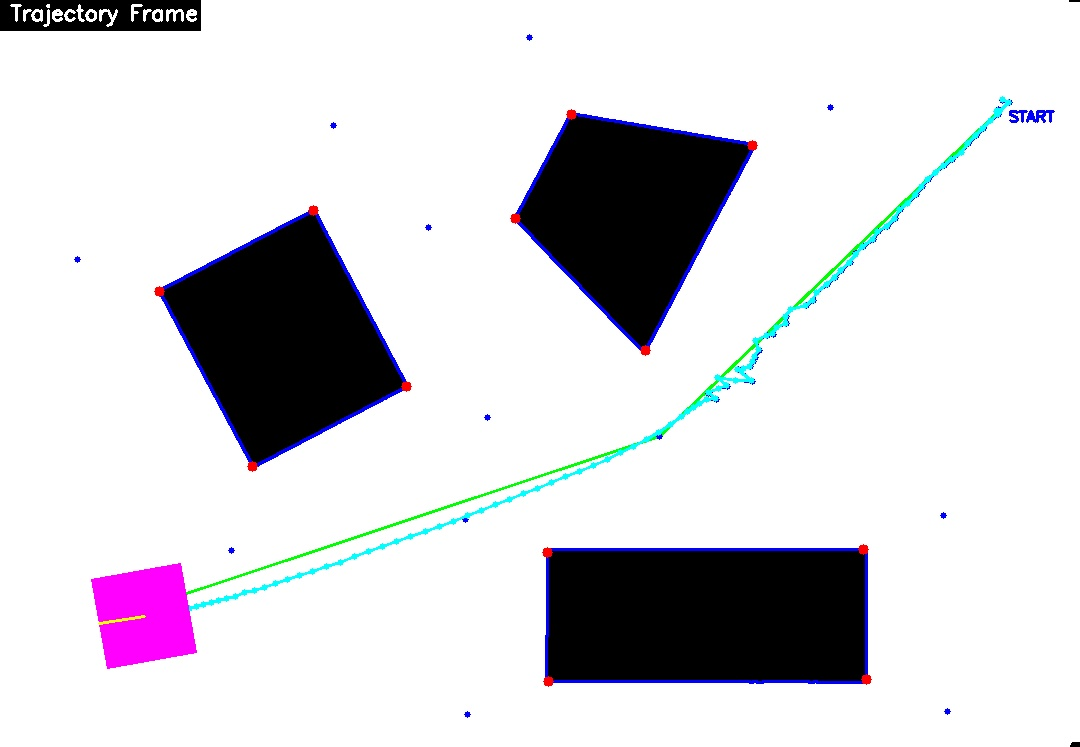

In [16]:
# Display variables
current_frame = None

# Positions variables
thymio_old_pos = thymio_pos
position_measured_history = []
filtered_position_history = [] 

# Flags variables
goal_reached = False

# Control variables
i = 0
covered = 0
left_speed = 0
right_speed = 0

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
        
    input("Press Enter to start the navigation...")
    
    while not goal_reached:
        i += 1
        
        # Camera Measurement
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        
        # Odometry Measurement
        left_measured_speed, right_measured_speed = get_speed()
        
        # EKF Prediction step with control inputs
        control_input = np.array([left_speed / SPEED_TO_MM_S, right_speed / SPEED_TO_MM_S])  
        ekf.predict(control_input)
        
        # Get current filtered state
        current_state, _ = ekf.get_state_and_covariance()

        if found_thymio:
            position_measured_history.append(thymio_pos[:2])
            
            # Use camera position and odometry for measurement
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
            if utils.distance(current_state[:2], thymio_old_pos[:2]) > KIDNAP_THRESHOLD:
                found_trajectory = False
                found_thymio = False
                motor_stop()
                
                input("Kidnapped! Press Enter when Thymio has been placed elsewhere...")
                vision.flush()
                while not found_trajectory:
                    while not found_thymio:
                        _, process_frame = vision.get_frame()
                        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
                        time.sleep(DT)
                    print("Thymio detected!")
                    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
                    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
                    
                    trajectory_frame = np.zeros_like(trajectory_frame)
                    trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                                   THYMIO_WIDTH, vision.scale_factor)
                    current_frame = trajectory_frame.copy()
                    current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                          vision.scale_factor, color=(255, 0, 0))

                    current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                        vision.scale_factor, color=(255, 255, 0))
                    
                    current_frame = utils.draw_robot(current_frame, thymio_pos, THYMIO_WIDTH, 
                                                     THYMIO_LENGTH, vision.scale_factor)
                    time.sleep(DT)
                    
                current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                                 filtered_position_history, current_state,
                                                                 THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
                    
                # Reinitialize the EKF after kidnapping
                ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0]))
                
                # Reset current checkpoint
                local_nav.current_checkpoint = 0
                
                utils.display_frames(None, frame, trajectory_frame)
            
                input("Press Enter to validate the new trajectory...")
                
        else: 
            covered += 1
            # Use filtered position when camera cannot see robot
            measurement = np.array([current_state[0], current_state[1], current_state[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
        thymio_old_pos = current_state[:3]
        
        # Update EKF with appropriate mode
        ekf.set_mode(covered=(not found_thymio))
        ekf.update(measurement)
        
        # Use filtered state for navigation
        filtered_state, _ = ekf.get_state_and_covariance()
        filtered_position_history.append(filtered_state[:2])
        
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_state[:3], sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
            left_speed = command['left_speed']
            right_speed = command['right_speed']
            set_speed(left_speed, right_speed)
            
        elif command['action'] == 'recompute_trajectory': # Recompute trajectory after obstacle avoidance
            found_trajectory = False
            while not found_trajectory:
                _, process_frame = vision.get_frame()
                trajectory_frame = np.zeros_like(trajectory_frame)
                trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, filtered_state[:3], goal_pos, obstacles_pos, 
                                                                                               THYMIO_WIDTH, vision.scale_factor)
                time.sleep(DT)
            current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                             filtered_position_history, current_state,
                                                             THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
            local_nav.current_checkpoint = 0
        else:
            motor_stop()
        
        current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                         filtered_position_history, current_state,
                                                         THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
        utils.display_frames(None, process_frame, current_frame) 
        time.sleep(DT)
        
except Exception as e:
    print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors, closing the webcam...")
finally:
    # Release resources
    vision.disconnect_webcam()
    motor_stop()
    print("Finished at time [s]:", i * DT)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, current_frame)
   

In [ ]:

await tdmclient.notebook.stop()
print("Successfully disconnected to Thymio.")

Successfully connected to Thymio.


In [29]:
from IPython.display import clear_output

# Rotation parameters
ANGLE_TOLERANCE = 5 # degrees
KP_ROTATION = 90
MAX_ROTATION_SPEED = 150

# Translation parameters
DISTANCE_TOLERANCE = 50 # mm
KP_TRANSLATION = 0.7 
MIN_TRANSLATION_SPEED = 100
MAX_TRANSLATION_SPEED = 200

# Obstacle avoidance parameters
OBSTACLES_MAX_ITER = 1
OBSTACLES_SPEED = 100
SCALE_SENSOR = 200
WEIGHT_LEFT = [ 5,  8, -10,  -8, -5]
WEIGHT_RIGHT = [-5, -8, -10, 8,  5]


In [40]:
def avoid_obstacles(sensor_data):
    sensor_data = sensor_data[:5]
    print(sensor_data)
    left_speed = 0
    right_speed = 0

    # Updates speed based on sensor data and their corresponding weights
    for i in range(len(sensor_data)):
        left_speed = left_speed + sensor_data[i] * WEIGHT_LEFT[i] / SCALE_SENSOR
        right_speed = right_speed + sensor_data[i] * WEIGHT_RIGHT[i] / SCALE_SENSOR

    command = {
            'action': 'avoid_obstacles',
            'left_speed': int(left_speed + OBSTACLES_SPEED),
            'right_speed': int(right_speed + OBSTACLES_SPEED)
        }
    return command, False

In [41]:
try:
    while 1:
        command, _ = avoid_obstacles(sensor_data())
        print(command)
        v_l = command['left_speed']
        v_r = command['right_speed']
        set_speed(v_l, v_r)
        clear_output(wait=True)
        time.sleep(0.2)
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors...")
finally:
    motor_stop()
    print("Motors stopped.")

User interrupted the kernel. Shutting down the motors...
Motors stopped.
